In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import FeatureHasher
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score,make_scorer,roc_curve
import scikitplot as skplt
import seaborn as sns
from scipy import stats
import datetime
from sklearn import tree

from sklearn import model_selection
from sklearn.feature_selection import RFE
from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV as CCV
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
import xgboost as xgb

from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)





## Loading Data

In [2]:
# Load the datasets

pokemon = pd.read_csv("pokemon.csv") 
battles = pd.read_csv("combats.csv")

In [3]:
battles.head()

First_pokemon  Second_pokemon  Winner
0            266             298     298
1            702             701     701
2            191             668     668
3            237             683     683
4            151             231     151

In [4]:
pokemon.head()

#           Name Type 1  Type 2  HP  Attack  Defense  Sp. Atk  Sp. Def  \
0  1      Bulbasaur  Grass  Poison  45      49       49       65       65   
1  2        Ivysaur  Grass  Poison  60      62       63       80       80   
2  3       Venusaur  Grass  Poison  80      82       83      100      100   
3  4  Mega Venusaur  Grass  Poison  80     100      123      122      120   
4  5     Charmander   Fire     NaN  39      52       43       60       50   

   Speed  Generation  Legendary  
0     45           1      False  
1     60           1      False  
2     80           1      False  
3     80           1      False  
4     65           1      False

## Data Exploration

In [5]:
 pokemon.info( )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        799 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   HP          800 non-null    int64 
 5   Attack      800 non-null    int64 
 6   Defense     800 non-null    int64 
 7   Sp. Atk     800 non-null    int64 
 8   Sp. Def     800 non-null    int64 
 9   Speed       800 non-null    int64 
 10  Generation  800 non-null    int64 
 11  Legendary   800 non-null    bool  
dtypes: bool(1), int64(8), object(3)
memory usage: 69.7+ KB


In [6]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pokemon.describe()

#     HP  Attack  Defense  Sp. Atk  Sp. Def  Speed  Generation
count 800.00 800.00  800.00   800.00   800.00   800.00 800.00      800.00
mean  400.50  69.26   79.00    73.84    72.82    71.90  68.28        3.32
std   231.08  25.53   32.46    31.18    32.72    27.83  29.06        1.66
min     1.00   1.00    5.00     5.00    10.00    20.00   5.00        1.00
25%   200.75  50.00   55.00    50.00    49.75    50.00  45.00        2.00
50%   400.50  65.00   75.00    70.00    65.00    70.00  65.00        3.00
75%   600.25  80.00  100.00    90.00    95.00    90.00  90.00        5.00
max   800.00 255.00  190.00   230.00   194.00   230.00 180.00        6.00

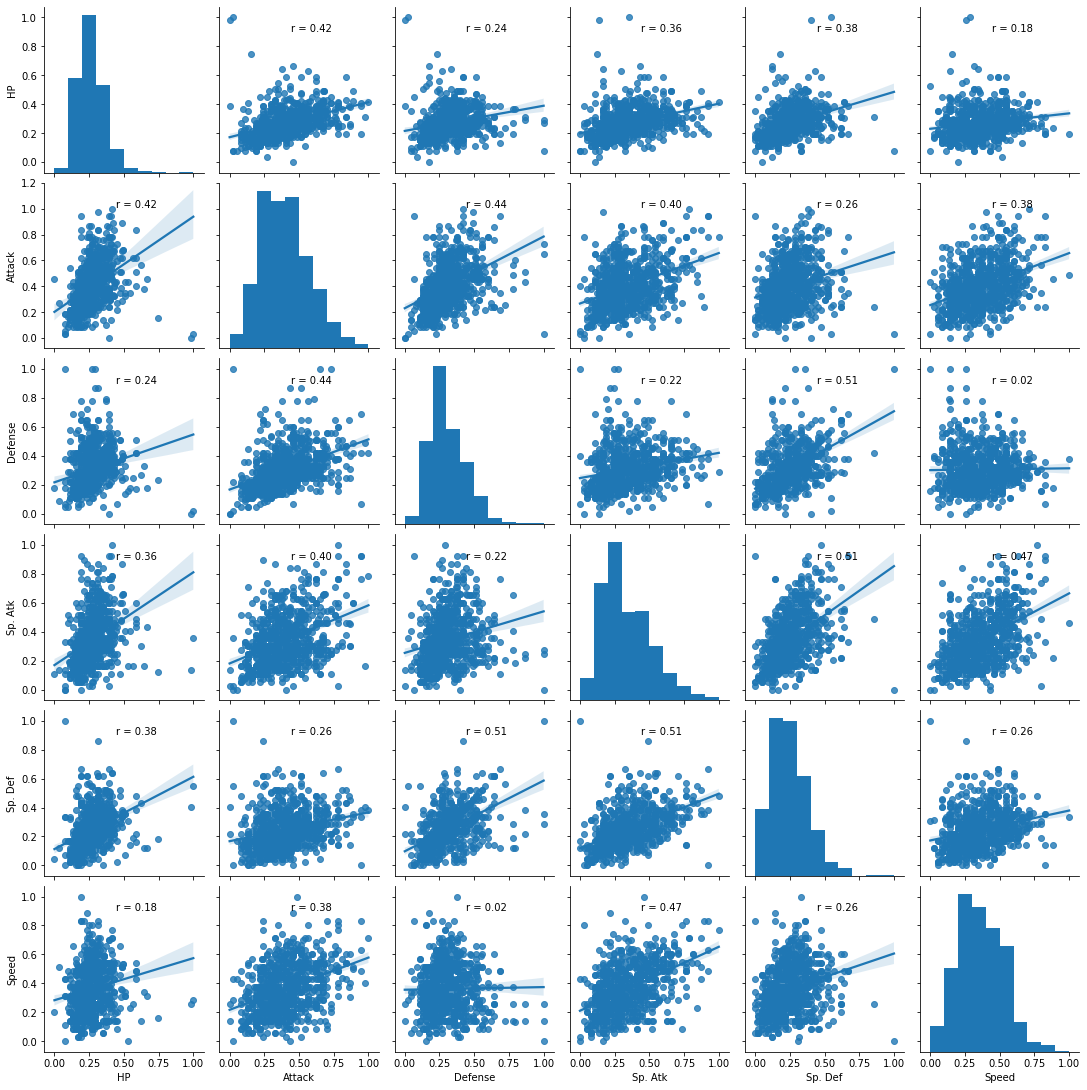

In [7]:
pokicat=pokemon[['#', 'Name', 'Type 1', 'Type 2', 'Generation', 'Legendary']]
pokidigit = pd.merge(
    pokemon,
    pokicat,
    on='#'
).loc[:, ['#', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']]

#Normalization
std_stats = pokidigit.set_index('#').apply(
    lambda x: (x - min(x)) /(max(x)-min(x)))
std_stats['strength'] = std_stats.sum(axis='columns')



#top 5 strogest combinations
joined = pd.merge(
    pokicat,
    std_stats,
    on='#'
)

means = joined.groupby(['Type 1', 'Type 2']).mean().loc[:, 'strength']

means.reset_index().sort_values('strength', ascending=False).head()




def show_corr(x, y, **kwargs):
    (r, _) = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate(
        'r = {:.2f}'.format(r),
        xy=(0.45, 0.85),
        xycoords=ax.transAxes
    )
sns.pairplot(
    data=joined.loc[:, 'HP':'Speed'],
    kind='reg'
).map_offdiag(show_corr);

#### All have positive r value; But no strong correlation

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024FD8EE5308>,
      dtype=object)

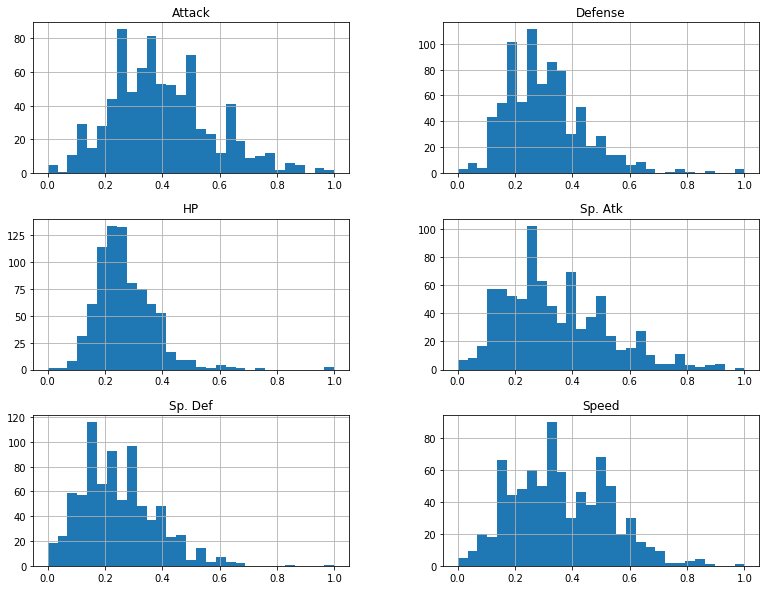

In [8]:
#Histograms for all continous features
%matplotlib inline
joined.hist(column=['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed'], bins=29, figsize=(13,10))

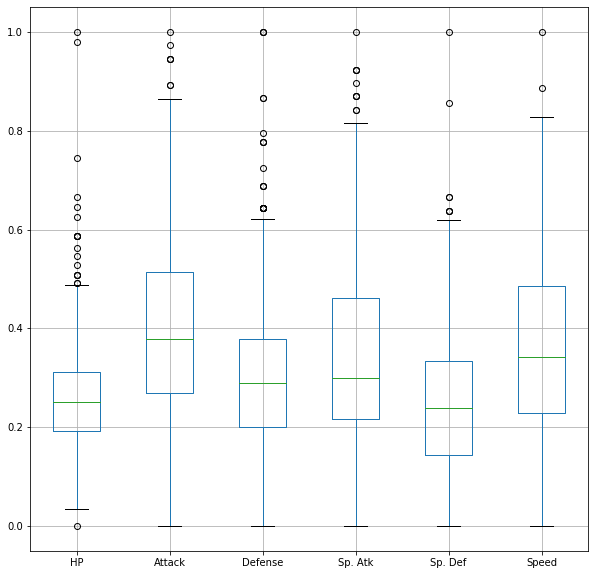

In [9]:
joined.boxplot(['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed'],figsize = (10,10))


In [10]:
s = battles['First_pokemon'].map(pokemon.set_index('#')['Name'])
df = battles.drop('First_pokemon', 1).assign(First_pokemon = s)
s1 = battles['Second_pokemon'].map(pokemon.set_index('#')['Name'])
df = df.drop('Second_pokemon', 1).assign(Second_pokemon = s1)
s2 = battles['Winner'].map(pokemon.set_index('#')['Name'])
df = df.drop('Winner', 1).assign(Winner = s2)

C:\Users\kehla\anaconda3\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


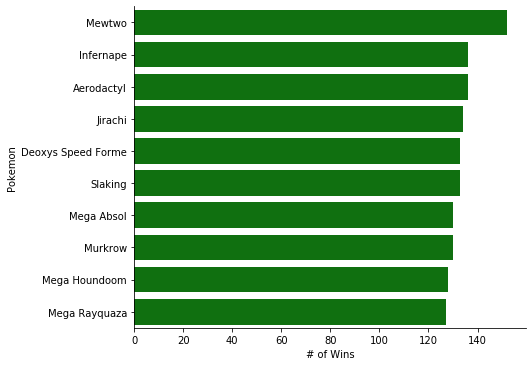

In [11]:
#Pokemons with highest number of wins
sns.factorplot(
    y='Winner',
    data=df,
    kind='count',
    order=df['Winner'].value_counts().iloc[:10].index,
    aspect=1.5,
    color='green'
).set_axis_labels('# of Wins', 'Pokemon')

In [12]:
std_stats.reset_index(inplace=True)
# Top 10 strongest pokemon
pd.merge(
    pokicat, 
    std_stats, 
    on='#'
).sort_values('strength', ascending=False).head(10)

#            Name   Type 1    Type 2  Generation  Legendary   HP  \
164  165   Mega Mewtwo Y  Psychic       NaN           1       True 0.41   
163  164   Mega Mewtwo X  Psychic  Fighting           1       True 0.41   
426  427   Mega Rayquaza   Dragon    Flying           3       True 0.41   
422  423   Primal Kyogre    Water       NaN           3       True 0.39   
424  425  Primal Groudon   Ground      Fire           3       True 0.39   
796  797    Mega Diancie     Rock     Fairy           6       True 0.19   
552  553          Arceus   Normal       NaN           4       True 0.47   
420  421     Mega Latios   Dragon   Psychic           3       True 0.31   
409  410  Mega Salamence   Dragon    Flying           3      False 0.37   
418  419     Mega Latias   Dragon   Psychic           3       True 0.31   

     Attack  Defense  Sp. Atk  Sp. Def  Speed  strength  
164    0.78     0.29     1.00     0.48   0.77      3.73  
163    1.00     0.42     0.78     0.38   0.71      3.71  
426    0.95     0.42     0.92     0.38   0.63      3.71  
422    0.78     0.38     0.92     0.67   0.49      3.63  
424    0.95     0.69     0.76     0.33   0.49      3.60  
796    0.84     0.47     0.82     0.43   0.60      3.34  
552    0.62     0.51     0.60     0.48   0.66      3.33  
420    0.68     0.42     0.82     0.48   0.60      3.30  
409    0.76     0.56     0.60     0.33   0.66      3.27  
418    0.51     0.51     0.71     0.62   0.60      3.26

## Data Preparation

In [13]:
# renaming the nameless pokemon
pokemon['Name'].fillna(value='Primeape', inplace=True)
#Replace type 2 null values with "None"
pokemon['Type 2'].fillna(value='None', inplace=True)

In [14]:
pokemon["Type 2"] = pokemon["Type 2"].fillna("NA")

In [15]:
# Convert "Legendary" column, False is converted to 0 and True is converted to 1.
pokemon["Legendary"] = pokemon["Legendary"].astype(int)

In [16]:
# covert strings to integers
h1 = FeatureHasher(n_features=4, input_type='string')
h2 = FeatureHasher(n_features=4, input_type='string')
d4 = h1.fit_transform(pokemon["Type 1"])
d5 = h2.fit_transform(pokemon["Type 2"])

In [17]:
f = d4.toarray()

unq = np.unique(f, axis=0)
print("nFeature Shape:", f.shape)
print("nUnique Shape:",unq.shape)


nFeature Shape: (800, 4)
nUnique Shape: (18, 4)


In [18]:
f1 = d5.toarray()

unq1 = np.unique(f1, axis=0)
print("nFeature Shape:", f1.shape)
print("nUnique Shape:",unq1.shape)


nFeature Shape: (800, 4)
nUnique Shape: (19, 4)


In [19]:
# Convert to dataframe
d1 = pd.DataFrame(data=d4.toarray())
d2 = pd.DataFrame(data=d5.toarray())

# Drop Type 1 and Type 2 column from Pokemon dataset and concatenate the above two dataframes.
pokemon = pokemon.drop(columns = ["Type 1", "Type 2"])
pokemon = pd.concat([pokemon, d1, d2], axis=1)

In [20]:
data = []
i = 0
for t in battles.itertuples():
    i += 1
    #print(i)
    first_pokemon = t[1]
    second_pokemon = t[2]
    winner = t[3]
    
    x = pokemon.loc[pokemon["#"]==first_pokemon].values[:, 2:][0]
    y = pokemon.loc[pokemon["#"]==second_pokemon].values[:, 2:][0]
    diff = (x-y)[:6]
    z = np.concatenate((x,y))
    
    if winner == first_pokemon:
        z = np.append(z, [0])
    else:
        z = np.append(z, [1])
        
    data.append(z)

In [21]:
data = np.asarray(data)

In [22]:
test=data[:, -1].astype(int)
(unique, counts) = np.unique(test, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)


[[    0 23601]
 [    1 26399]]


## Model Processing

In [23]:
X = data[:, :-1].astype(int)
y = data[:, -1].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [24]:
# prepare models
models = []

# Classifiers to use in Voting
boost = xgb.XGBClassifier()
dtc = DecisionTreeClassifier(max_depth=5, criterion='entropy')
lrg = LogisticRegression(solver='liblinear')
vote = VotingClassifier(estimators=[('boost', boost), ('dtc', dtc), ('lrg', lrg)], voting='soft')

models.append(('LRG', LogisticRegression(solver='liblinear', max_iter=250)))
models.append(('KNB', KNeighborsClassifier()))
models.append(('GNB', GaussianNB()))
#models.append(('XGB', xgb.XGBClassifier(random_state=0)))
models.append(('RFC', RandomForestClassifier(random_state=0, n_estimators=100)))
models.append(('DTC', DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=5)))
models.append(('SVC', LinearSVC(random_state=0,dual=False)))
#models.append(('VOTE', VotingClassifier(estimators=[('boost', boost), ('dtc', dtc), ('lrg', lrg)], voting='soft')))
#models.append(('CCV', CCV(vote, method='isotonic', cv=3)))
#models.append(('MLP', MLPClassifier()))
models.append(('ADA', AdaBoostClassifier(random_state=0)))

# evaluate each model by average of roc auc 
results_dict = {}

for name, m in models:
    kfold = model_selection.KFold(n_splits=10) 
    cv_results = model_selection.cross_val_score(m, X_train, y_train, cv=kfold, scoring = 'roc_auc') # or 'accuracy'
    results_dict.update({name: "%f" % cv_results.mean()})

In [25]:
# results_dict
sorted(((v,k) for k,v in results_dict.items()), reverse=True)

[('0.981635', 'RFC'),
 ('0.954552', 'DTC'),
 ('0.933941', 'KNB'),
 ('0.927422', 'LRG'),
 ('0.926793', 'SVC'),
 ('0.917204', 'ADA'),
 ('0.842869', 'GNB')]

# Random Forest

In [26]:
# Fit best model to all of training set
rf = RandomForestClassifier(random_state=0, n_estimators=100)
model = rf.fit(X_train, y_train)
print('Random Forest Classifier \nAccuracy:{0:.3f}'.format(model.score(X_test, y_test)))

Random Forest Classifier 
Accuracy:0.943


In [27]:
print(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

0.9822034885450179


In [28]:
# Fit best model to all of training set
rf = RandomForestClassifier(random_state=0, n_estimators=200)
model = rf.fit(X_train, y_train)
print('Random Forest Classifier \nAccuracy:{0:.3f}'.format(model.score(X_test, y_test)))

Random Forest Classifier 
Accuracy:0.946


In [29]:
# Fit best model to all of training set
rf = RandomForestClassifier(random_state=0, n_estimators=1000)
model = rf.fit(X_train, y_train)
print('Random Forest Classifier \nAccuracy:{0:.3f}'.format(model.score(X_test, y_test)))

Random Forest Classifier 
Accuracy:0.949


# Add hyper tuning code here

In [30]:
# Random forest with 200 has the highest accuracy
rf_clf = RandomForestClassifier(random_state=0, n_estimators=200)
rf_model = rf_clf.fit(X_train,y_train)
rf_pred = rf_model.predict(X_test)
print(f"Expected : {y_test}")
print(f"Predicted : {rf_pred}")

Expected : [1 0 0 ... 1 1 1]
Predicted : [1 0 0 ... 1 1 1]


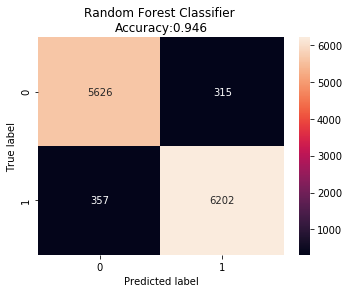

In [31]:
cm = metrics.confusion_matrix(y_test, rf_pred)

plt.figure(figsize=(5.5,4))
sns.heatmap(cm, annot=True, fmt="g")
plt.title('Random Forest Classifier \nAccuracy:{0:.3f}'.format(rf_model.score(X_test, y_test)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [32]:
print('Accuracy :', accuracy_score(y_test,rf_pred))
print(classification_report(y_test, rf_pred))

Accuracy : 0.94624
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      5941
           1       0.95      0.95      0.95      6559

    accuracy                           0.95     12500
   macro avg       0.95      0.95      0.95     12500
weighted avg       0.95      0.95      0.95     12500



In [33]:
print(roc_auc_score(y_test, rf_model.predict_proba(X_test)[:,1]))

0.9828223195620891


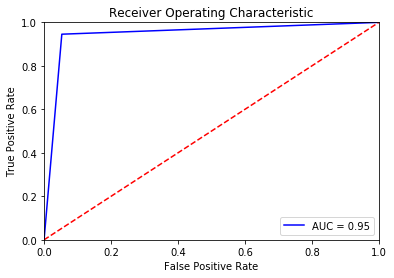

In [34]:
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = roc_curve(y_test, rf_pred)
roc_auc = auc(fpr, tpr)

# method I: plt

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

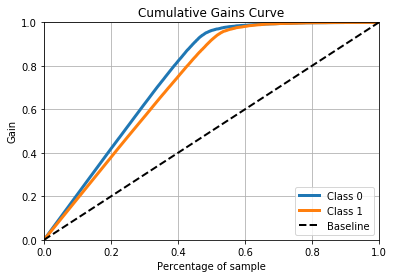

In [35]:
cumu=skplt.metrics.plot_cumulative_gain(y_test,rf_model.predict_proba(X_test))

### Code for running head to head winner pred

In [36]:
"""from google.colab import drive
drive.mount('/content/gdrive')
import torch
model_save_name = 'pokemon_rf.pt'
path = f"/content/gdrive/MyDrive/'Colab Notebooks'/245/{model_save_name}" 
torch.save(rf_model, "/content/gdrive/MyDrive/Colab Notebooks/245/pokemon_rf.pt")
model = torch.load("/content/gdrive/MyDrive/Colab Notebooks/245/pokemon_rf.pt")"""

'from google.colab import drive\ndrive.mount(\'/content/gdrive\')\nimport torch\nmodel_save_name = \'pokemon_rf.pt\'\npath = f"/content/gdrive/MyDrive/\'Colab Notebooks\'/245/{model_save_name}" \ntorch.save(rf_model, "/content/gdrive/MyDrive/Colab Notebooks/245/pokemon_rf.pt")\nmodel = torch.load("/content/gdrive/MyDrive/Colab Notebooks/245/pokemon_rf.pt")'

In [37]:
"""first = input("Enter First Pokemon: ")
second = input("Enter Second Pokemon: ")"""

'first = input("Enter First Pokemon: ")\nsecond = input("Enter Second Pokemon: ")'

In [38]:
"""x = pokemon.loc[pokemon["Name"]==first].values[:, 2:][0]
y = pokemon.loc[pokemon["Name"]==second].values[:, 2:][0]
z = np.concatenate((x,y))
z = np.asarray(z)
X_sample = z[:].astype(int)
rf_pred = rf_model.predict([X_sample])
if rf_pred ==0:
  print(f"Predicted winner : {first}")
else:
  print(f"Predicted winner : {second}")"""

'x = pokemon.loc[pokemon["Name"]==first].values[:, 2:][0]\ny = pokemon.loc[pokemon["Name"]==second].values[:, 2:][0]\nz = np.concatenate((x,y))\nz = np.asarray(z)\nX_sample = z[:].astype(int)\nrf_pred = rf_model.predict([X_sample])\nif rf_pred ==0:\n  print(f"Predicted winner : {first}")\nelse:\n  print(f"Predicted winner : {second}")'

# Sample Tree of Random Forest

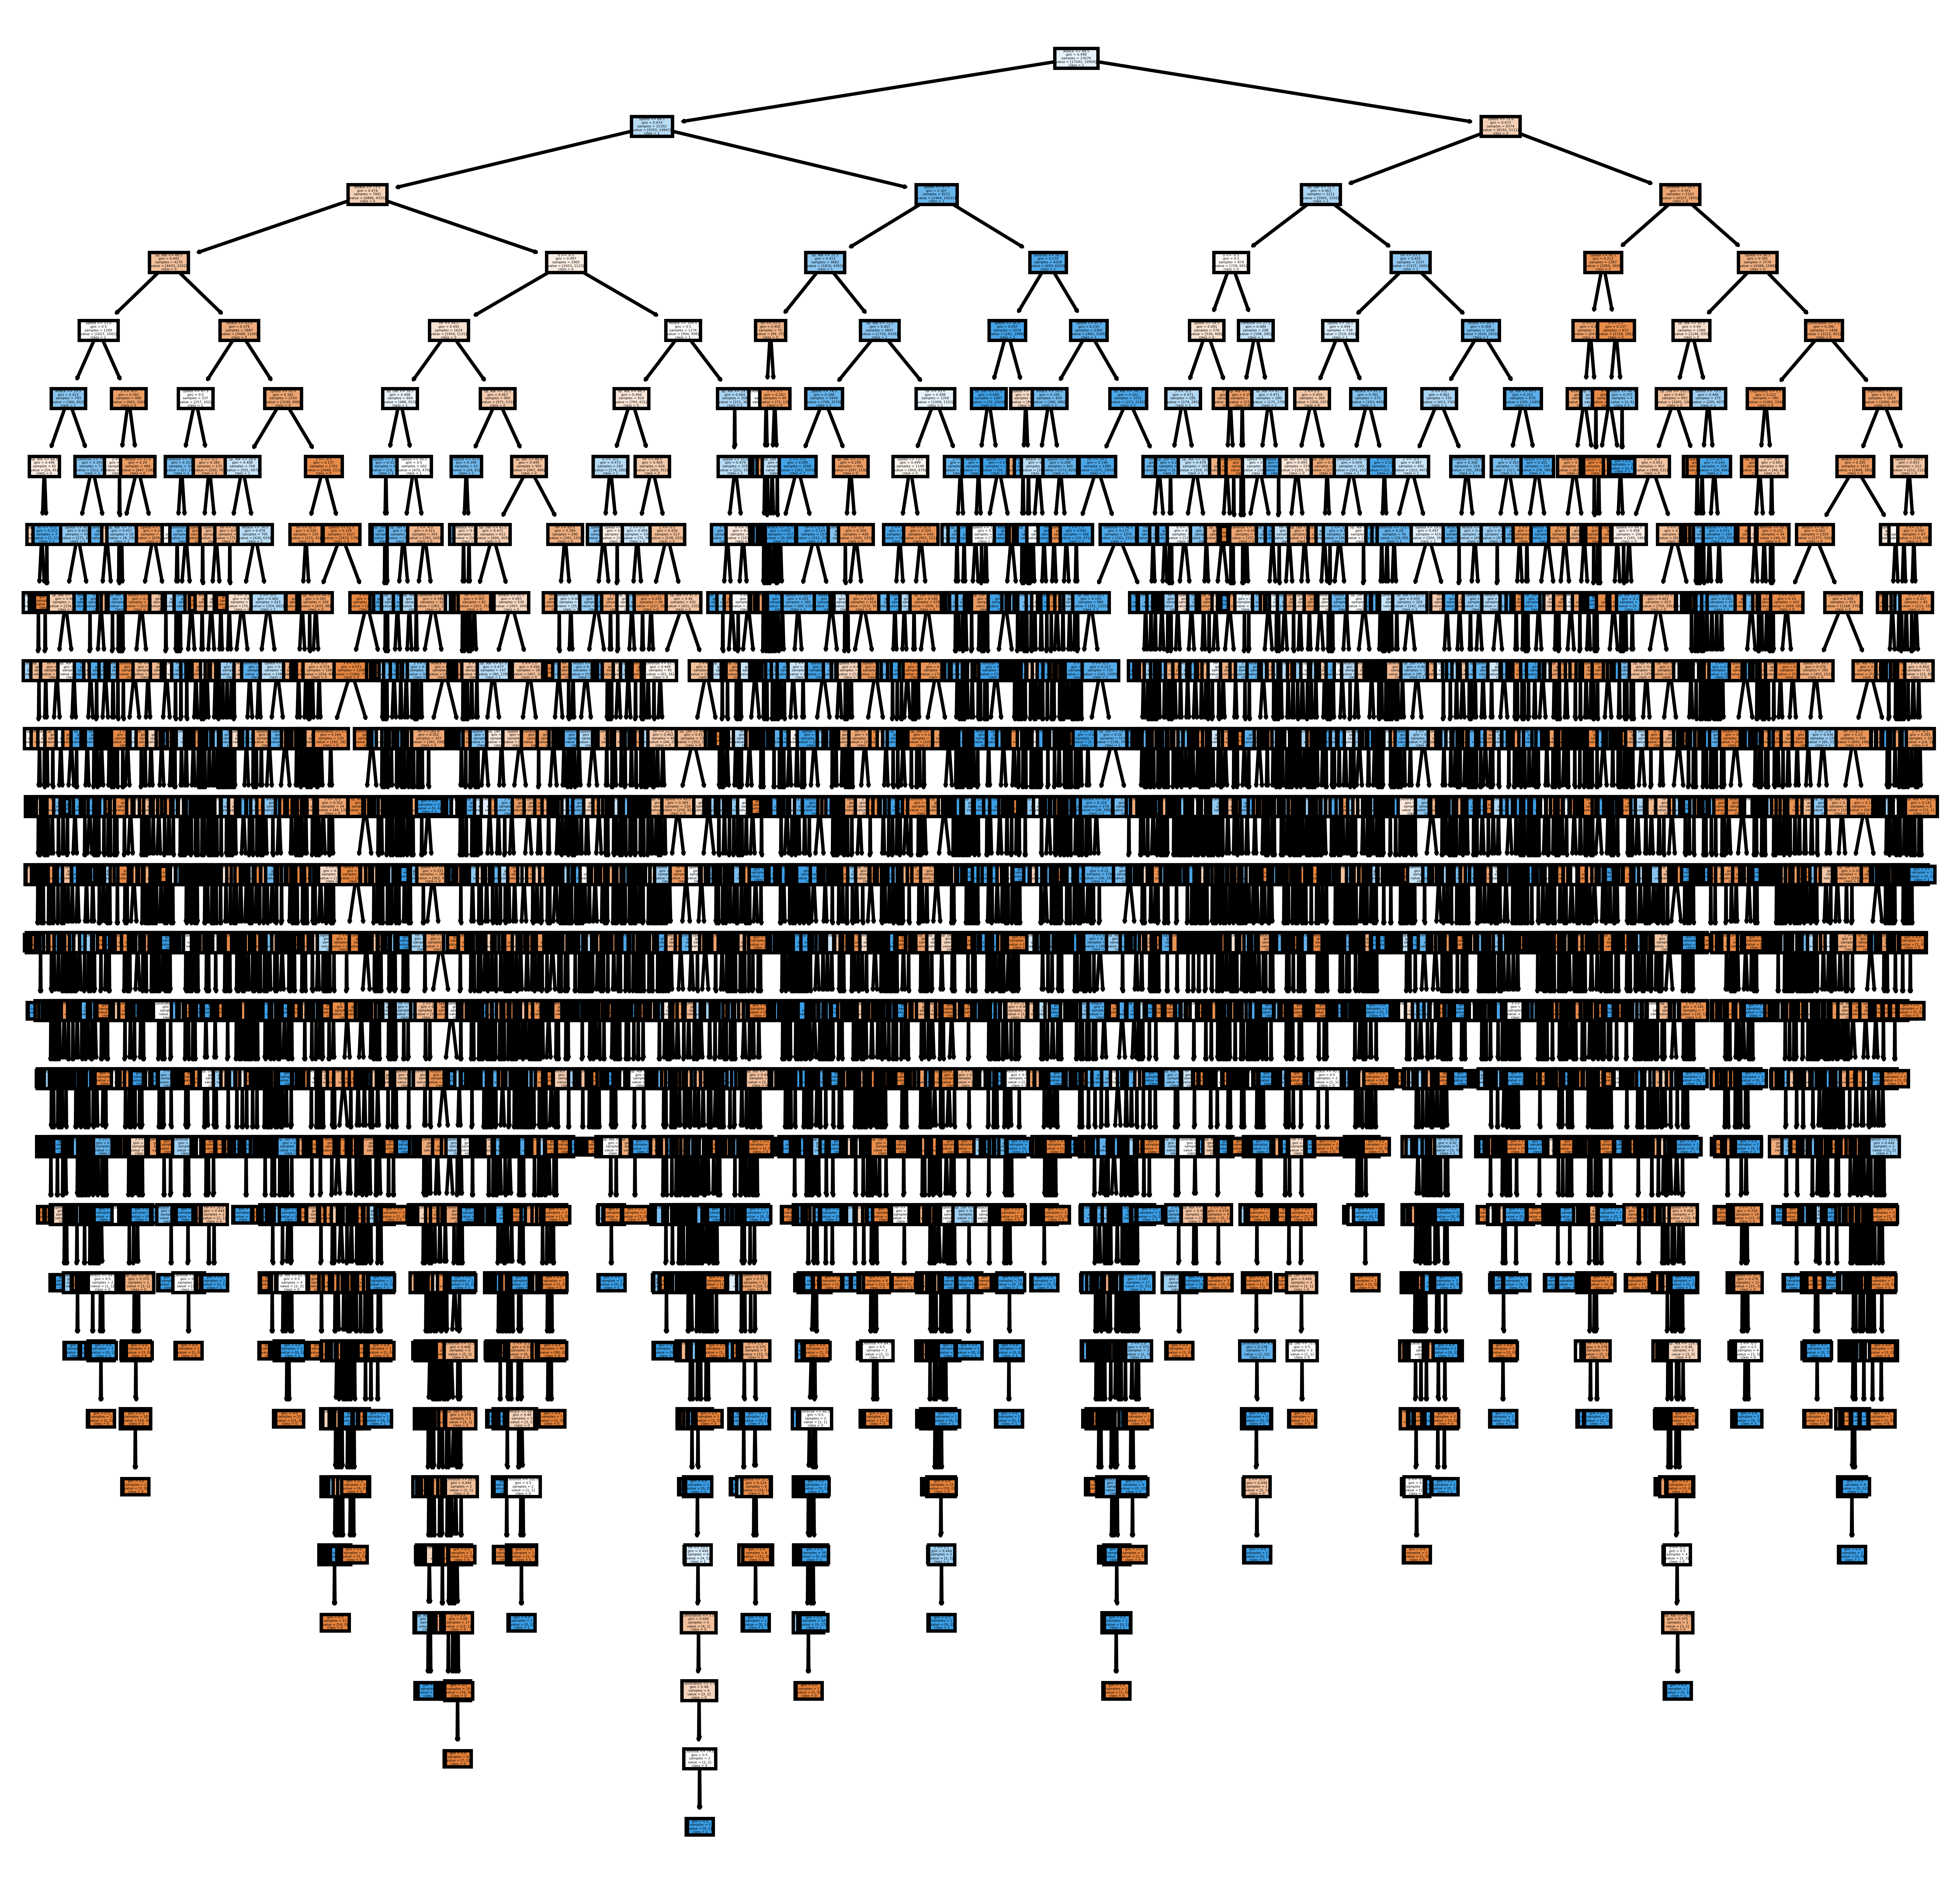

In [39]:

fn=['HP','Attack','Defense','Sp. Atk','Sp. Def','Speed','Generation','Legendary','0','1','2','3','0','1','2','3','HP',	'Attack',	'Defense',	'Sp. Atk',	'Sp. Def',	'Speed',	'Generation',	'Legendary',	'0',	'1',	'2',	'3',	'0',	'1',	'2',	'3']
cn=['0','1']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=800)
tree.plot_tree(rf.estimators_[0],
               feature_names = fn, 
               class_names=cn,
               filled = True);
fig.savefig('rf_individualtree.png')

# Decision Tree

In [40]:
# Decision Tree 
dt_clf =DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=5)
dt_model = dt_clf.fit(X_train,y_train)
dt_pred = dt_model.predict(X_test)
print(f"Expected : {y_test}")
print(f"Predicted : {dt_pred}")

Expected : [1 0 0 ... 1 1 1]
Predicted : [1 0 0 ... 1 1 1]


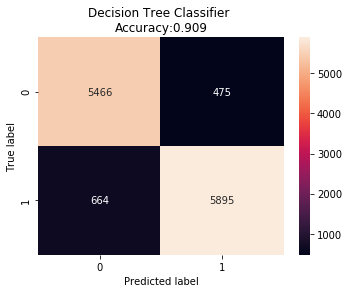

In [41]:
cm = metrics.confusion_matrix(y_test, dt_pred)

plt.figure(figsize=(5.5,4))
sns.heatmap(cm, annot=True, fmt="g")
plt.title('Decision Tree Classifier \nAccuracy:{0:.3f}'.format(dt_model.score(X_test, y_test)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [42]:
print('Accuracy :', accuracy_score(y_test,dt_pred))
print(classification_report(y_test, dt_pred))

Accuracy : 0.90888
              precision    recall  f1-score   support

           0       0.89      0.92      0.91      5941
           1       0.93      0.90      0.91      6559

    accuracy                           0.91     12500
   macro avg       0.91      0.91      0.91     12500
weighted avg       0.91      0.91      0.91     12500



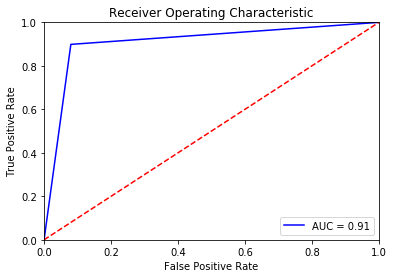

In [43]:
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = roc_curve(y_test, dt_pred)
roc_auc = auc(fpr, tpr)

# method I: plt

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

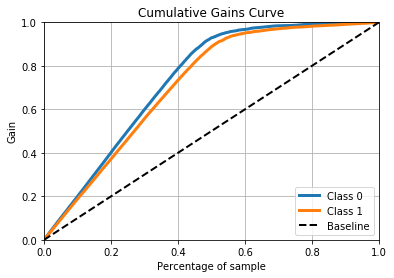

In [44]:
cumu=skplt.metrics.plot_cumulative_gain(y_test,dt_model.predict_proba(X_test))

# Logisitc Regression

In [45]:
# Logistic Regression
lrg_clf =LogisticRegression(solver='liblinear', max_iter=250)
lrg_model = lrg_clf.fit(X_train,y_train)
lrg_pred = lrg_model.predict(X_test)
print(f"Expected : {y_test}")
print(f"Predicted : {lrg_pred}")

Expected : [1 0 0 ... 1 1 1]
Predicted : [1 0 0 ... 1 1 1]


In [46]:
print('Accuracy :', accuracy_score(y_test,lrg_pred))
print(classification_report(y_test, lrg_pred))

Accuracy : 0.88976
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      5941
           1       0.89      0.90      0.90      6559

    accuracy                           0.89     12500
   macro avg       0.89      0.89      0.89     12500
weighted avg       0.89      0.89      0.89     12500



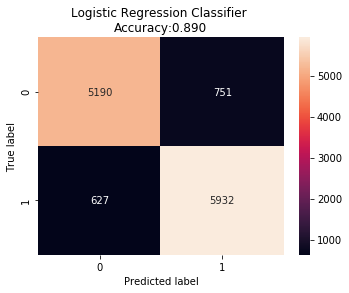

In [47]:
cm = metrics.confusion_matrix(y_test, lrg_pred)

plt.figure(figsize=(5.5,4))
sns.heatmap(cm, annot=True, fmt="g")
plt.title('Logistic Regression Classifier \nAccuracy:{0:.3f}'.format(lrg_model.score(X_test, y_test)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

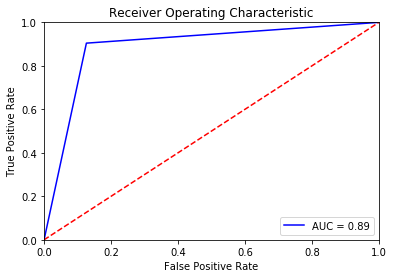

In [48]:
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = roc_curve(y_test, lrg_pred)
roc_auc = auc(fpr, tpr)

# method I: plt

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

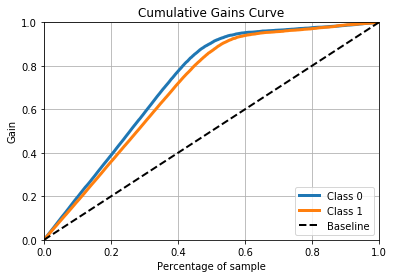

In [49]:
cumu=skplt.metrics.plot_cumulative_gain(y_test,lrg_model.predict_proba(X_test))

# SVM

In [50]:
svm_clf =LinearSVC(random_state=0,dual=False)
svm_model = svm_clf.fit(X_train,y_train)
svm_pred = svm_model.predict(X_test)
print(f"Expected : {y_test}")
print(f"Predicted : {svm_pred}")

Expected : [1 0 0 ... 1 1 1]
Predicted : [1 0 0 ... 1 1 1]


In [51]:
print('Accuracy :', accuracy_score(y_test,svm_pred))
print(classification_report(y_test, svm_pred))

Accuracy : 0.8856
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      5941
           1       0.88      0.90      0.89      6559

    accuracy                           0.89     12500
   macro avg       0.89      0.88      0.89     12500
weighted avg       0.89      0.89      0.89     12500



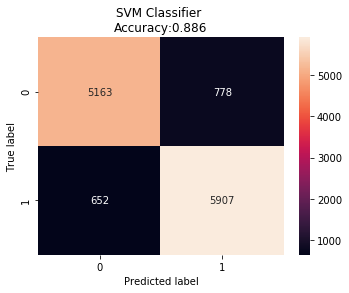

In [52]:
cm = metrics.confusion_matrix(y_test, svm_pred)

plt.figure(figsize=(5.5,4))
sns.heatmap(cm, annot=True, fmt="g")
plt.title('SVM Classifier \nAccuracy:{0:.3f}'.format(svm_model.score(X_test, y_test)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

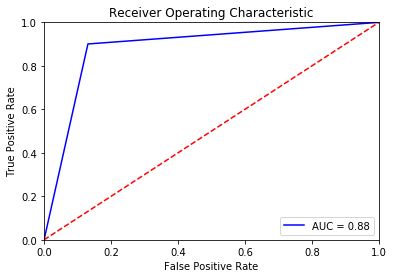

In [53]:
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = roc_curve(y_test, svm_pred)
roc_auc = auc(fpr, tpr)

# method I: plt

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# ADA Boost

In [54]:
# ADA Boost
ada_clf =AdaBoostClassifier(random_state=0)
ada_model = ada_clf.fit(X_train,y_train)
ada_pred = ada_model.predict(X_test)
print(f"Expected : {y_test}")
print(f"Predicted : {ada_pred}")

Expected : [1 0 0 ... 1 1 1]
Predicted : [1 0 0 ... 1 1 1]


In [55]:
print('Accuracy :', accuracy_score(y_test,ada_pred))
print(classification_report(y_test, ada_pred))

Accuracy : 0.85
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      5941
           1       0.84      0.87      0.86      6559

    accuracy                           0.85     12500
   macro avg       0.85      0.85      0.85     12500
weighted avg       0.85      0.85      0.85     12500



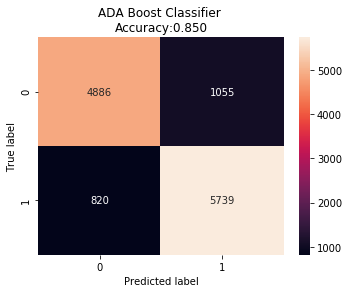

In [56]:
cm = metrics.confusion_matrix(y_test, ada_pred)

plt.figure(figsize=(5.5,4))
sns.heatmap(cm, annot=True, fmt="g")
plt.title('ADA Boost Classifier \nAccuracy:{0:.3f}'.format(ada_model.score(X_test, y_test)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

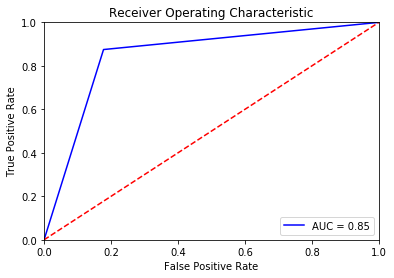

In [57]:
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = roc_curve(y_test, ada_pred)
roc_auc = auc(fpr, tpr)

# method I: plt

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

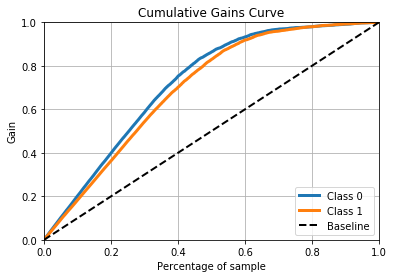

In [58]:
cumu=skplt.metrics.plot_cumulative_gain(y_test,ada_model.predict_proba(X_test))

# Normalized SVM

In [59]:
# SVM

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

svm_clf = make_pipeline(StandardScaler(), svm.SVC(kernel='linear'))
svm_model = svm_clf.fit(X_train,y_train)
svm_pred = svm_model.predict(X_test)
print(f"Expected : {y_test}")
print(f"Predicted : {svm_pred}")

Expected : [1 0 0 ... 1 1 1]
Predicted : [1 0 0 ... 1 1 1]


In [60]:
print('Accuracy :', accuracy_score(svm_pred, y_test))

print(classification_report(y_test, svm_pred))

Accuracy : 0.91072
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      5941
           1       0.91      0.92      0.92      6559

    accuracy                           0.91     12500
   macro avg       0.91      0.91      0.91     12500
weighted avg       0.91      0.91      0.91     12500



In [61]:
# SVM

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

svm_clf = make_pipeline(StandardScaler(), svm.SVC(kernel='poly'))
svm_model = svm_clf.fit(X_train,y_train)
svm_pred = svm_model.predict(X_test)
print(f"Expected : {y_test}")
print(f"Predicted : {svm_pred}")

Expected : [1 0 0 ... 1 1 1]
Predicted : [1 0 0 ... 1 1 1]


In [62]:
# SVM

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

svm_clf = make_pipeline(StandardScaler(), svm.SVC(kernel='sigmoid'))
svm_model = svm_clf.fit(X_train,y_train)
svm_pred = svm_model.predict(X_test)
print(f"Expected : {y_test}")
print(f"Predicted : {svm_pred}")

Expected : [1 0 0 ... 1 1 1]
Predicted : [1 0 0 ... 1 1 1]


In [63]:
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)


# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=0, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)



print('Random Forest Classifier \nAccuracy:{0:.3f}'.format(rf_random.score(X_test, y_test)))




rf_random.best_params_


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.8min finished


Random Forest Classifier 
Accuracy:0.952


{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 90,
 'bootstrap': False}

In [65]:

import torch
model_save_name = 'pokemon_rf.pt'
path = f"C:\\Users\\kehla\\Downloads\\{model_save_name}" 
torch.save(rf_model, path)
model = torch.load(path)

In [66]:


def torcall(first_poke,second_poke):
    x = pokemon.loc[pokemon["Name"]==first_poke].values[:, 2:][0]
    y = pokemon.loc[pokemon["Name"]==second_poke].values[:, 2:][0]
    z = np.concatenate((x,y))
    z = np.asarray(z)
    X_sample = z[:].astype(int)
    dt_pred = dt_model.predict([X_sample])
    if dt_pred ==0:
        print(f"Predicted winner : {first_poke}")
    else:
        print(f"Predicted winner : {second_poke}")


In [67]:
torcall('Blastoise','Charizard')

Predicted winner : Charizard
